In [1]:
%matplotlib inline
%load_ext autotime

import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics
import sklearn.preprocessing

In [3]:
# %env OMP_NUM_THREADS=1
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4
time: 135 ms


In [4]:
import torch
import torch.multiprocessing as mp

time: 284 ms


In [5]:
# import libs.yellowfin as yf
import sys
sys.path.append( '/data/pytorch-test' )
import yellowfin as yf

time: 18.1 ms


In [6]:
import collections
import time
import os

time: 2.79 ms


In [7]:
%config InlineBackend.figure_format = 'retina'
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 18.5 ms


# parameters

In [9]:
hidden_dim = 128
batch_size = 10000
epochs = 1000

time: 2.41 ms


# load data

In [13]:
from torch.utils.data import Dataset

class WineDataset( Dataset ):
    def __init__( self ):
        df = pd.concat( [
            pd.read_csv( 'datasets/winequality-red.csv', sep=';' ),
            pd.read_csv( 'datasets/winequality-white.csv', sep=';' ),
        ], 0 ).reset_index( drop=True )
        self._x = sk.preprocessing.MinMaxScaler().fit_transform( df.drop( 'quality', 1 ).values )
        self._y = df.quality.values - df.quality.min()
    def __len__( self ):
        return self._x.shape[ 0 ]
    def __getitem__( self, idx ):
        x = self._x[ idx ]
        y = self._y[ idx ]
        return torch.FloatTensor( x ), y
    @property
    def xdim( self ):
        return self._x.shape[ 1 ]
    @property
    def ydim( self ):
        return len( np.unique( self._y ) )

time: 26.3 ms


In [14]:
def load_data():
    ds = WineDataset()
    train_loader = torch.utils.data.DataLoader( ds, batch_size=batch_size, shuffle=True )
#     test_loader = torch.utils.data.DataLoader( ds, batch_size=batch_size, shuffle=True )
    return train_loader#, test_loader

time: 3.56 ms


In [15]:
ds = WineDataset()
train_loader = load_data()
test_loader = load_data()

time: 79.6 ms


# YellowFin (sync)

In [16]:
m1 = torch.nn.Sequential(
    torch.nn.Linear( ds.xdim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, ds.ydim ),
    torch.nn.Softmax(),
)

time: 11 ms


In [17]:
criterion1 = torch.nn.NLLLoss()
optimizer1 = yf.YFOptimizer( m1.parameters(), lr=1., mu=0. )#, weight_decay=5e-4 )

time: 1.72 ms


In [18]:
def train( rank, model, epochs, q=None, lock=None ):
    starttime = time.time()
    history = collections.defaultdict( list )
    pid = str( os.getpid() )
    train_loader = load_data()
    model.train()
    criterion = torch.nn.NLLLoss()
    optimizer = yf.YFOptimizer( model.parameters(), lr=1., mu=0. )
    if rank == 0:
        print( '\tepoch\tloss\taccuracy' )
    for epoch in range( epochs ):
        train_loss = 0
        correct = 0
        total = 0
        for _, ( inputs, targets ) in enumerate( train_loader ):
            optimizer.zero_grad()
            inputs, targets = torch.autograd.Variable( inputs ), torch.autograd.Variable( targets )
            outputs = model( inputs )
            loss = criterion( outputs, targets )
            loss.backward()
            optimizer.step()

            train_loss += loss.data[ 0 ]
            correct += torch.max( outputs.data, 1 )[ 1 ].eq( targets.data ).cpu().sum()
            total += targets.size( 0 )

            history[ 't' ].append( time.time() )
            history[ 'loss' ].append( loss.data[ 0 ] )
            if type( optimizer ) == yf.YFOptimizer:
                history[ 'lr' ].append( optimizer._optimizer.param_groups[ 0 ][ 'lr' ] )
                history[ 'mu' ].append( optimizer._optimizer.param_groups[ 0 ][ 'momentum' ] )
                history[ 'hmin' ].append( optimizer._h_min if hasattr( optimizer, '_h_min' ) else .00012345 )
                history[ 'hmax' ].append( optimizer._h_max if hasattr( optimizer, '_h_max' ) else .00012345 )
        if epochs // 10 == 0 or epoch % ( epochs // 10 ) == 0:
            print( '%r\t%r\t%g\t%g\t[%r/%r]\t%g min(s)' % ( pid, epoch, train_loss, 100. * correct / total, correct, total, ( time.time() - starttime ) / 60. ) )
    if q is not None:
        q.put( history )
    return history

time: 96.3 ms


In [19]:
history = train( 0, m1, epochs )

	epoch	loss	accuracy
'1060'	0	-0.140803	10.4664	[680/6497]	0.00557097 min(s)
'1060'	100	-0.580986	58.6886	[3813/6497]	0.445512 min(s)
'1060'	200	-0.582205	58.5193	[3802/6497]	0.863312 min(s)
'1060'	300	-0.614273	61.767	[4013/6497]	1.26401 min(s)
'1060'	400	-0.620628	62.1518	[4038/6497]	1.6722 min(s)
'1060'	500	-0.646533	65.0608	[4227/6497]	2.04248 min(s)
'1060'	600	-0.669203	67.0617	[4357/6497]	2.41751 min(s)
'1060'	700	-0.672595	67.5389	[4388/6497]	2.78638 min(s)
'1060'	800	-0.683523	68.6625	[4461/6497]	3.20527 min(s)
'1060'	900	-0.708751	70.8789	[4605/6497]	3.67993 min(s)
time: 4min 4s


In [20]:
test_loss = 0
correct = 0
total = 0
m1.eval()
for batch_idx, ( inputs, targets ) in enumerate( test_loader ):
    inputs, targets = torch.autograd.Variable( inputs ), torch.autograd.Variable( targets )
    outputs = m1( inputs )
    loss = criterion1( outputs, targets )
    
    test_loss += loss.data[ 0 ]
    correct += torch.max( outputs.data, 1 )[ 1 ].eq( targets.data ).cpu().sum()
    total += targets.size( 0 )
print( 'loss:', test_loss )
print( 'correct: %g [%r/%r]' % ( 100. * correct / total, correct, total ) )

loss: -0.7089812755584717
correct: 70.9097 [4607/6497]
time: 196 ms


(1.0, 10.070811769552632)

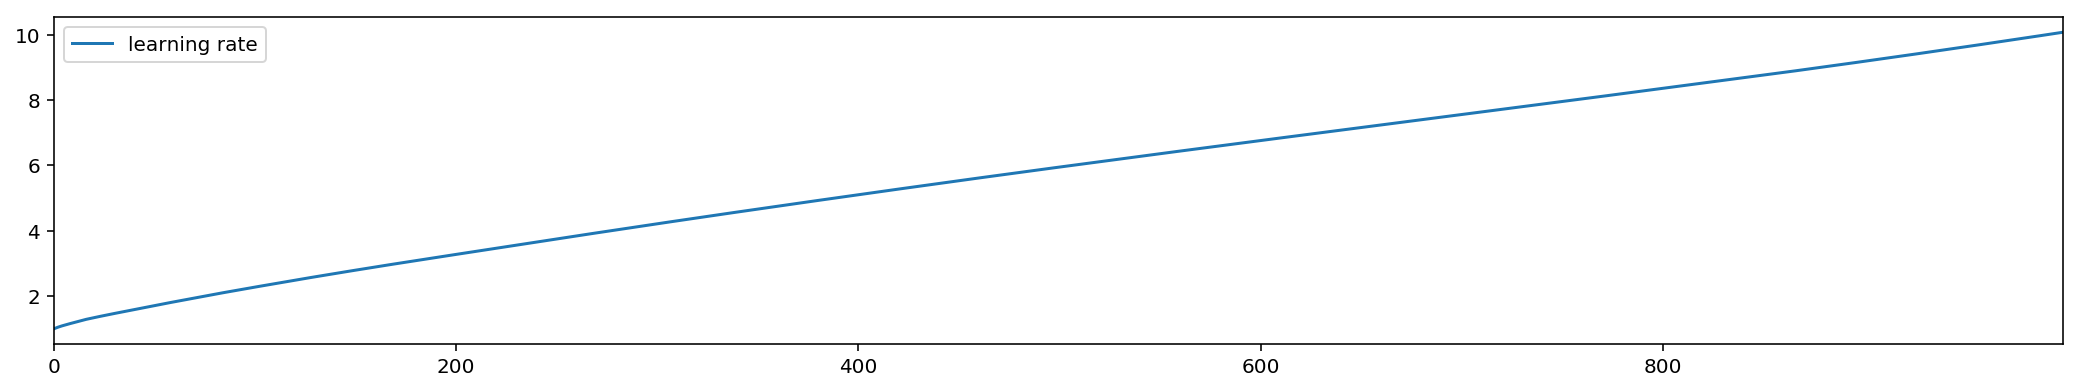

time: 383 ms


In [21]:
_ = pd.Series( history[ 'lr' ], name='learning rate' ).plot.line( legend=True )
min( history[ 'lr' ] ), max( history[ 'lr' ] )

(0.0, 0.26715348191257915)

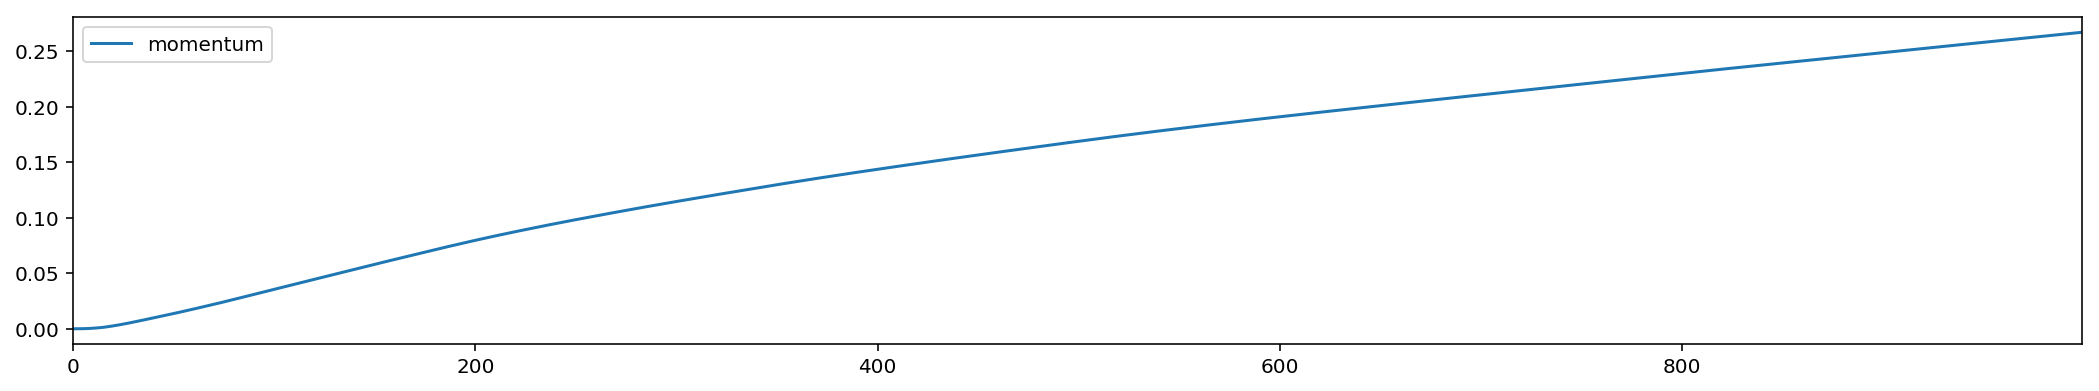

time: 338 ms


In [22]:
_ = pd.Series( history[ 'mu' ], name='momentum' ).plot.line( legend=True )
min( history[ 'mu' ] ), max( history[ 'mu' ] )

(0.0055494536994432474,
 0.034235496073961744,
 0.026474715396462612,
 0.06269984320241058)

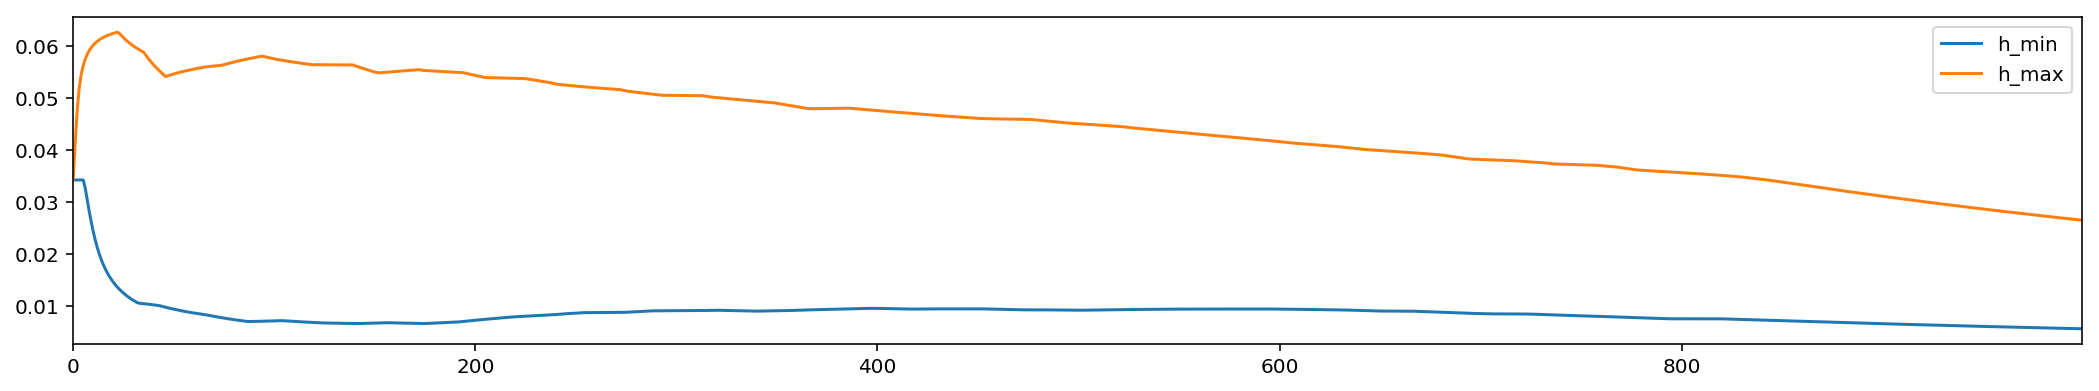

time: 332 ms


In [23]:
_ = pd.Series( history[ 'hmin' ], name='h_min' ).plot.line( legend=True )
_ = pd.Series( history[ 'hmax' ], name='h_max' ).plot.line( legend=True )
min( history[ 'hmin' ] ), max( history[ 'hmin' ] ), min( history[ 'hmax' ] ), max( history[ 'hmax' ] )

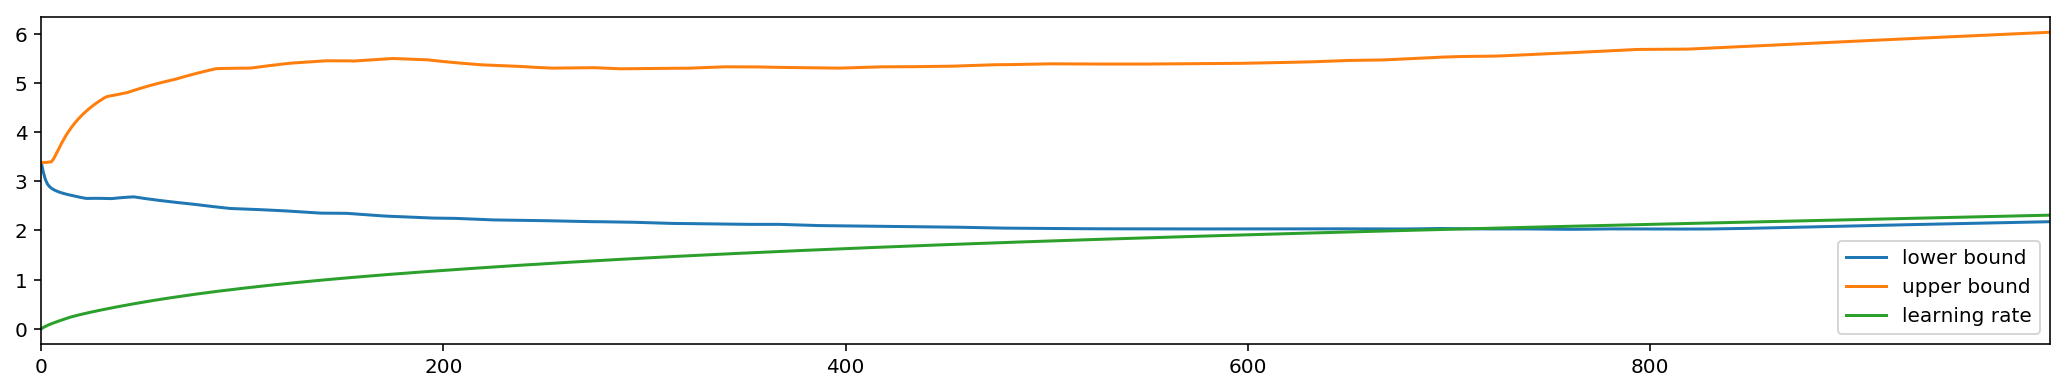

time: 357 ms


In [24]:
_ = pd.Series( np.log( np.divide( np.power( 1. - np.sqrt( history[ 'mu' ] ), 2 ), history[ 'hmax' ] ) ), name='lower bound' ).plot( legend=True )
_ = pd.Series( np.log( np.divide( np.power( 1. + np.sqrt( history[ 'mu' ] ), 2 ), history[ 'hmin' ] ) ), name='upper bound' ).plot( legend=True )
_ = pd.Series( np.log( history[ 'lr' ] ), name='learning rate' ).plot( legend=True )

# YellowFin (async)

In [16]:
m2 = torch.nn.Sequential(
    torch.nn.Linear( ds.xdim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, hidden_dim ),
    torch.nn.BatchNorm1d( hidden_dim ),
    torch.nn.ReLU(),
    torch.nn.Linear( hidden_dim, ds.ydim ),
    torch.nn.Softmax(),
)
_ = m2.share_memory()

time: 80.4 ms


In [17]:
import concurrent.futures

time: 980 µs


In [18]:
def train2( rank, model, epochs, q=None, lock=None ):
    starttime = time.time()
    history = collections.defaultdict( list )
    pid = str( os.getpid() )
    train_loader = load_data()
    model.train()
    criterion = torch.nn.NLLLoss()
    optimizer = yf.AsyncYFOptimizer( model.parameters(), lr=1., mu=0. )
    if rank == 0:
        print( '\tepoch\tloss\taccuracy' )
    for epoch in range( epochs ):
        train_loss = 0
        correct = 0
        total = 0
        for _, ( inputs, targets ) in enumerate( train_loader ):
            optimizer.zero_grad()
            inputs, targets = torch.autograd.Variable( inputs ), torch.autograd.Variable( targets )
            outputs = model( inputs )
            loss = criterion( outputs, targets )
            loss.backward()
            if np.isnan( loss.data[ 0 ] ):
                print( 'loss:', loss.data[ 0 ] )
                print( 'lr:', optimizer._lr )
                print( 'mu:', optimizer._mu )
                print( 'h_min:', optimizer._h_min )
                print( 'h_max:', optimizer._h_max )
                print( 'mu_total:', optimizer._mu_total )
            optimizer.step()

            train_loss += loss.data[ 0 ]
            correct += torch.max( outputs.data, 1 )[ 1 ].eq( targets.data ).cpu().sum()
            total += targets.size( 0 )

            history[ 't' ].append( time.time() )
            history[ 'loss' ].append( loss.data[ 0 ] )
            if type( optimizer ) == yf.AsyncYFOptimizer:
                history[ 'lr' ].append( optimizer._lr )
                history[ 'mu' ].append( optimizer._mu )
                history[ 'hmin' ].append( optimizer._h_min if hasattr( optimizer, '_h_min' ) else .00012345 )
                history[ 'hmax' ].append( optimizer._h_max if hasattr( optimizer, '_h_max' ) else .00012345 )
                history[ 'mu_total' ].append( optimizer._mu_total )
        if epochs // 10 == 0 or epoch % ( epochs // 10 ) == 0:
            print( '%r\t%r\t%g\t%g\t[%r/%r]\t%g min(s)' % ( pid, epoch, train_loss, 100. * correct / total, correct, total, ( time.time() - starttime ) / 60. ) )
    if q is not None:
        q.put( history )
    return history

time: 95.7 ms


In [19]:
processes = []
num_processes = 3 #mp.cpu_count()
manager = mp.Manager()
q = manager.Queue()
lock = manager.Lock()

for rank in range( num_processes ):
    p = mp.Process( target=train2, args=( rank, m2, epochs, q ) ) #, lock ) )
    p.start()
    processes.append( p )
for p in processes:
    p.join()

	epoch	loss	accuracy
'934'	0	-0.129362	3.27844	[213/6497]	0.00455028 min(s)
'931'	0	-0.129362	3.27844	[213/6497]	0.00491459 min(s)
'928'	0	-0.129362	3.27844	[213/6497]	0.00544676 min(s)
'931'	100	-0.58409	58.5655	[3805/6497]	0.373069 min(s)
'928'	100	-0.603374	60.551	[3934/6497]	0.376822 min(s)
'934'	100	-0.603374	60.551	[3934/6497]	0.377128 min(s)
'931'	200	-0.623656	62.6443	[4070/6497]	0.735634 min(s)
'928'	200	-0.641059	64.5375	[4193/6497]	0.738259 min(s)
'934'	200	-0.623493	62.7366	[4076/6497]	0.738933 min(s)
'931'	300	-0.642481	64.3066	[4178/6497]	1.09348 min(s)
'928'	300	-0.63065	63.1676	[4104/6497]	1.0964 min(s)
'934'	300	-0.657059	65.7842	[4274/6497]	1.09802 min(s)
'931'	400	-0.691455	69.2935	[4502/6497]	1.45451 min(s)
'928'	400	-0.678797	67.9852	[4417/6497]	1.45518 min(s)
'934'	400	-0.668446	67.0002	[4353/6497]	1.45917 min(s)
'928'	500	-0.699794	70.0169	[4549/6497]	1.8203 min(s)
'931'	500	-0.69649	69.863	[4539/6497]	1.82126 min(s)
'934'	500	-0.707149	70.8943	[4606/6497]	1.8248

In [22]:
histories = [ q.get() for _ in range( q.qsize() ) ]
histories = pd.concat( [ pd.DataFrame( histories[ i ] ) for i in range( len( histories ) ) ], 0 ).sort_values( 't' ).reset_index( drop=True )
histories.shape

(3000, 7)

time: 30.2 ms


(0.99009900990099009, 19.730580541674243)

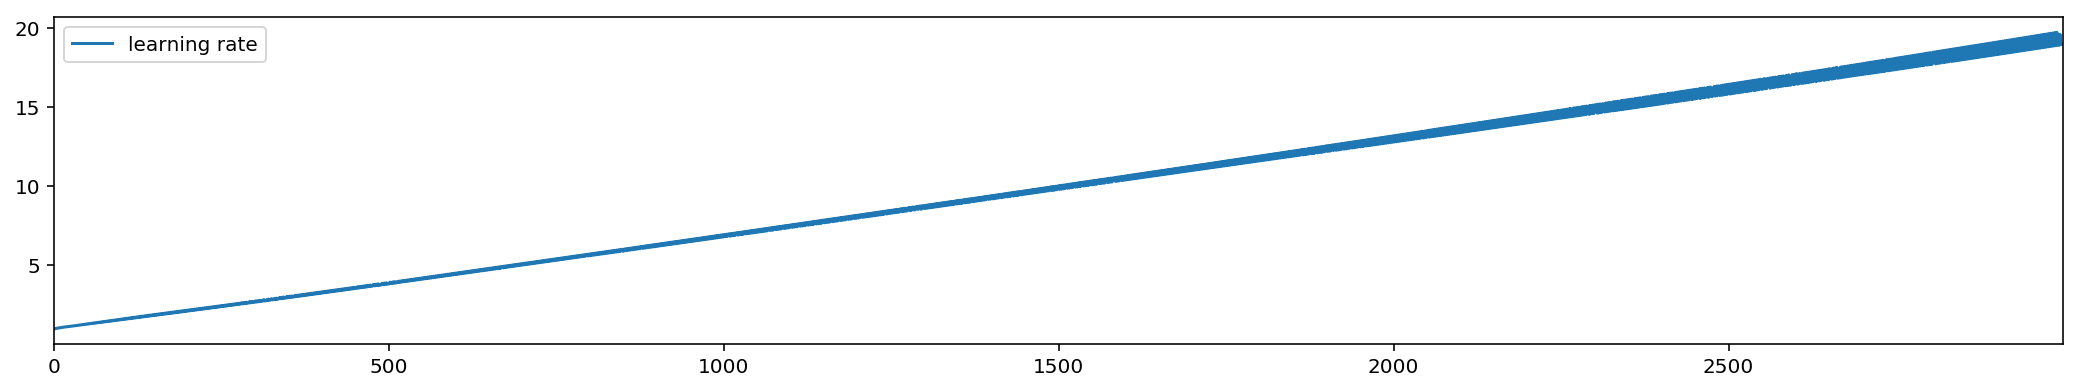

time: 344 ms


In [23]:
_ = pd.Series( histories.lr, name='learning rate' ).plot( legend=True )
histories.lr.min(), histories.lr.max()

(-0.090467102993369242, 5.8471406243157904e-05)

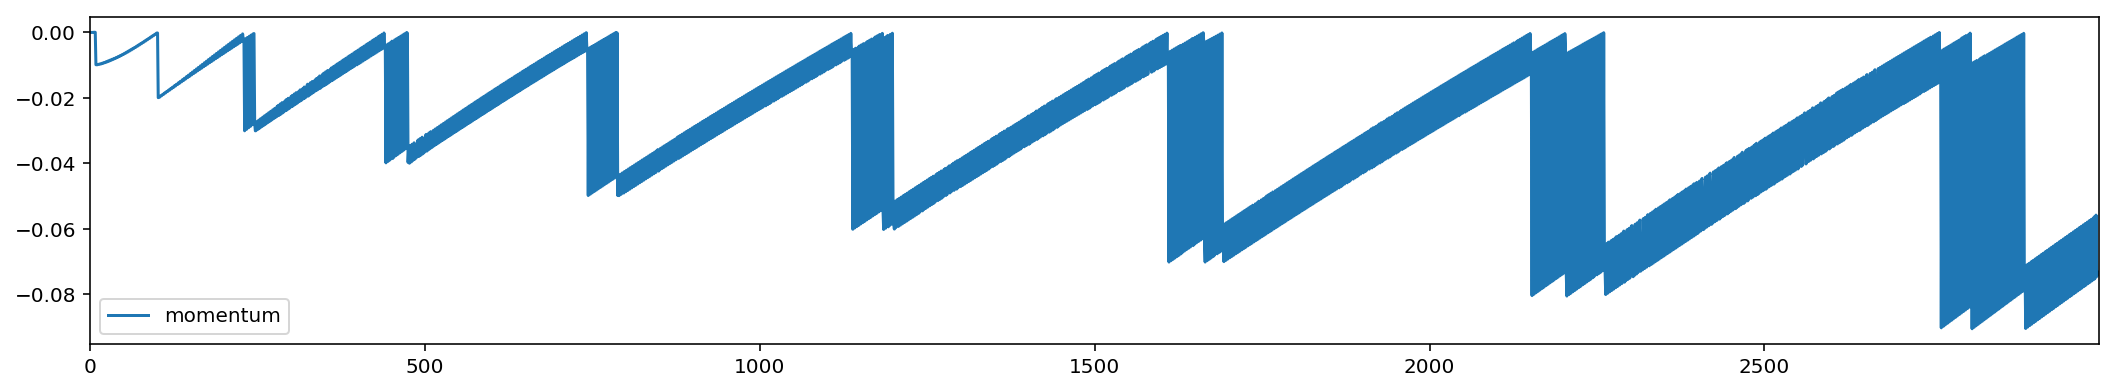

time: 353 ms


In [24]:
_ = pd.Series( histories.mu, name='momentum' ).plot.line( legend=True )
histories.mu.min(), histories.mu.max()

(0.0, 9.0631125951185822)

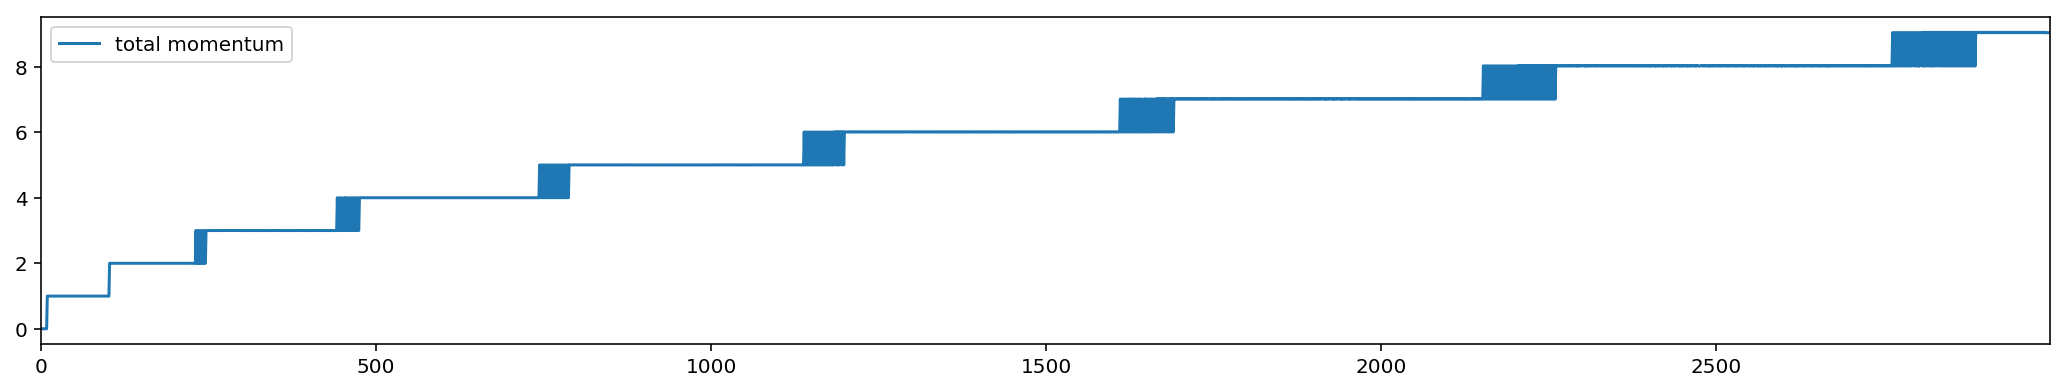

time: 285 ms


In [25]:
_ = pd.Series( histories.mu_total, name='total momentum' ).plot.line( legend=True )
histories.mu_total.min(), histories.mu_total.max()

(0.0037157284558824726,
 0.025880342349410432,
 0.011938022046094182,
 0.043282762900804739)

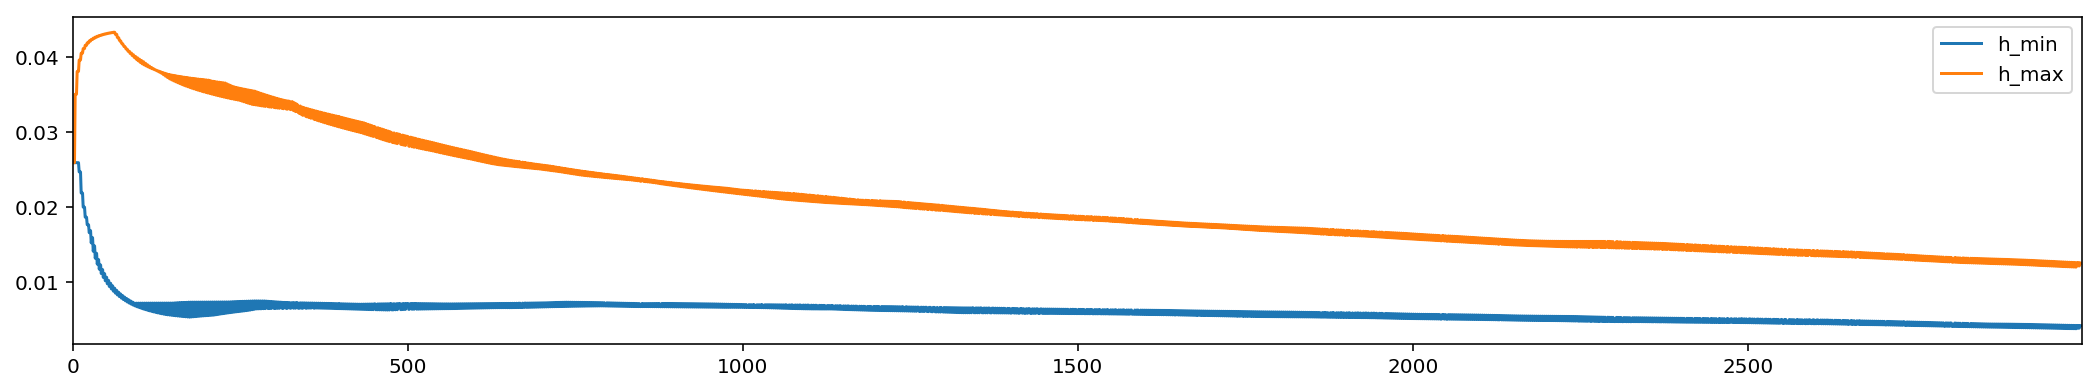

time: 375 ms


In [26]:
_ = pd.Series( histories.hmin, name='h_min' ).plot.line( legend=True )
_ = pd.Series( histories.hmax, name='h_max' ).plot.line( legend=True )
histories.hmin.min(), histories.hmin.max(), histories.hmax.min(), histories.hmax.max()

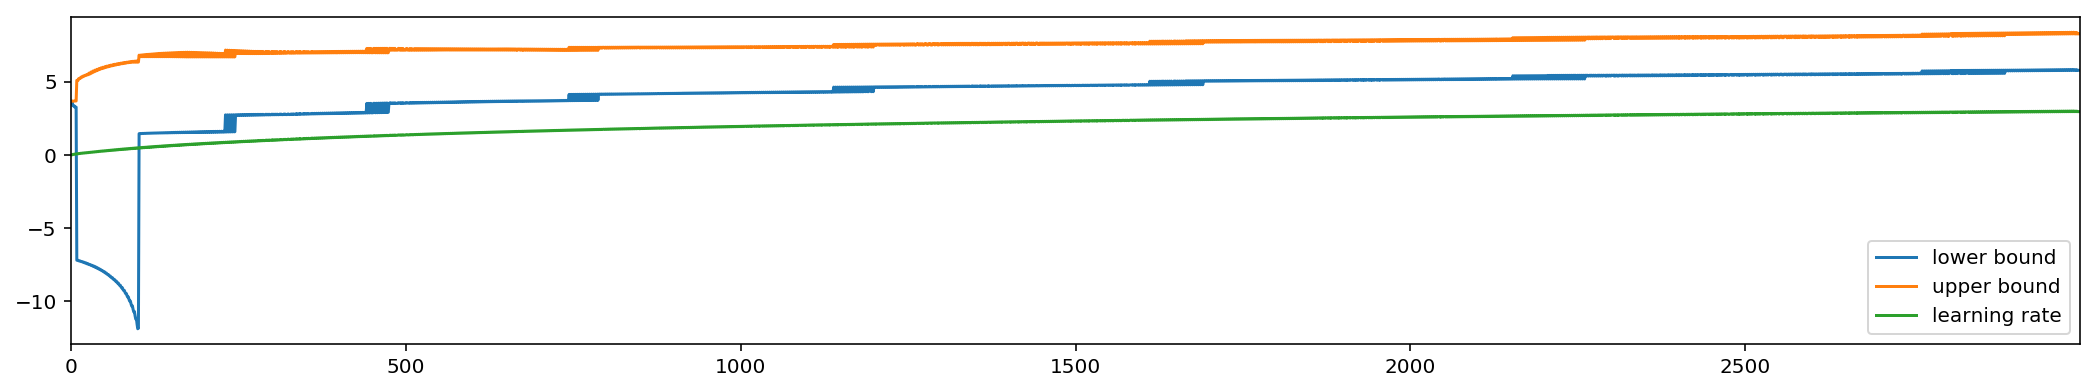

time: 399 ms


In [31]:
_ = pd.Series( np.log( np.divide( np.power( 1. - np.sqrt( histories.mu + histories.mu_total ), 2 ), histories.hmax ) ), name='lower bound' ).plot( legend=True )
_ = pd.Series( np.log( np.divide( np.power( 1. + np.sqrt( histories.mu + histories.mu_total ), 2 ), histories.hmin ) ), name='upper bound' ).plot( legend=True )
_ = pd.Series( np.log( histories.lr ), name='learning rate' ).plot( legend=True )